# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing_reddit_data')

### Set file paths

In [2]:
file_comments = "../../../data/reddit/AmericanPolitics_comments.zst"
file_submissions = "../../../data/reddit/AmericanPolitics_submissions.zst"

subreddit_here = "AmericanPolitics"
subreddit = "AmericanPolitics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
#import gurobipy
#from gurobipy import *

pd.options.mode.chained_assignment = None

In [ ]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import filter_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

In [8]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

In [9]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

## Plot

* watch out, no cleaning of tokens so far

0
1657
word_count
1       8076
6       2498
8       2396
9       2389
7       2376
        ... 
614        1
1470       1
576        1
570        1
1096       1
Name: count, Length: 784, dtype: int64


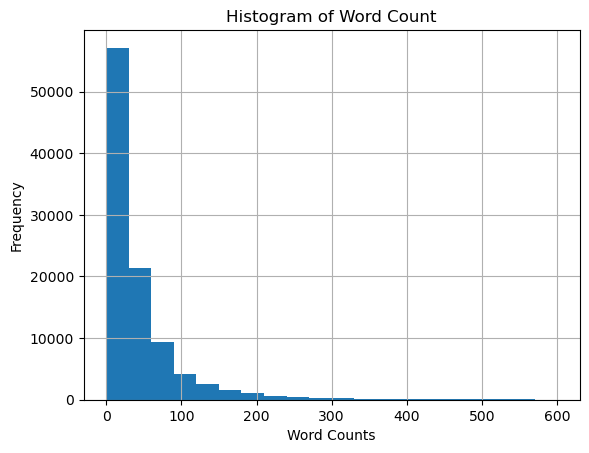

In [10]:
df_comments_replies["tokens"] = df_comments_replies["body"].apply(lambda x: x.split())
df_comments_replies["word_count"] = df_comments_replies["tokens"].apply(len)

print(df_comments_replies['word_count'].min())
print(df_comments_replies['word_count'].max())
print(df_comments_replies['word_count'].value_counts())

fig, ax = plt.subplots()
ax.hist(df_comments_replies['word_count'], bins = 20, range = (0, 600))
ax.set_title("Histogram of Word Count")
#ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) 
#ax.set_xticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"])  
ax.set_xlabel("Word Counts")
ax.set_ylabel("Frequency")
ax.grid(True)

### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [11]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

1.8178405678405678
Number of relevant submissions: 12693
Lost submissions:  50426


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,[deleted],1.215555e+09,6quhn,2qied,[deleted],6quhn,c04mjyb,c04mjyb,1.0,1,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2008-07-09,comment
1,matts2,1.215608e+09,6quhn,2qied,I am not sure that it is a terrible idea. The ...,6quhn,c04mqzf,c04mqzf,0.0,0,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2008-07-09,comment
2,bluespapa,1.216257e+09,6s3ac,2qied,There wouldn't be subpoenas if he looked like ...,6s3ac,c04pyjw,c04pyjw,2.0,2,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2008-07-17,comment
3,OsakaWilson,1.216299e+09,6s3ac,2qied,If they don't have the balls to drag these guy...,6s3ac,c04q3ok,c04q3ok,2.0,2,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2008-07-17,comment
4,BravoLima,1.216322e+09,6s9x8,2qied,http://en.wikipedia.org/wiki/Hitler_Jugend ...,6s9x8,c04q9uc,c04q9uc,1.0,1,0.0,AmericanPolitics,NaN,NaN,NaN,NaN,NaN,2008-07-17,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36654,00__rabbitking__00,1.704049e+09,18ve5n4,2qied,"Oh, so we're a democracy now.",18ve5n4,kfqekp4,kfqekp4,3.0,3,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-31,comment
36655,modilion,1.704055e+09,18ve5n4,2qied,Yeah... the danger that a [rapist](https://www...,18ve5n4,kfqux74,kfqux74,8.0,8,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-31,comment
36656,machinade89,1.704057e+09,18ve5n4,2qied,She's hardly a zealot. She's doing what the re...,18ve5n4,kfr0iug,kfr0iug,7.0,7,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-31,comment
36657,chaz4224,1.704061e+09,18ve5n4,2qied,"what load, dumpty definitely committed treaso...",18ve5n4,kfrb4cr,kfrb4cr,1.0,1,0.0,AmericanPolitics,NaN,,False,True,NaN,2023-12-31,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [12]:
df_left = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'left')
df_inner = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner') # correct join

print("Left Join:", len(df_left))
print("Inner Join: ", len(df_inner))

print("Length of children in left, that are in inner as well: ", len(df_left[~df_left['msg_id_child'].isin(df_inner['msg_id_child'])]))
print("Difference: ", len(df_left) - len(df_inner))

Left Join: 15681
Inner Join:  11784
Length of children in left, that are in inner as well:  3897
Difference:  3897


In [13]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner')
df_matched

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0515ak,c05164b,Maybe with all the Controlled-Media hype you m...,AmericanPolitics,1.218659e+09,BravoLima,-1.0,-1,0.0,6w6jw,...,pablogott,1.0,1,0.0,1.218657e+09,,BravoLima,NaN,0,1.218651e+09
1,c050z3z,c0516d4,I agree.\n\nIt is more telling when you read a...,AmericanPolitics,1.218660e+09,dmehrtash,2.0,2,0.0,6w4lo,...,matts2,0.0,0,0.0,1.218631e+09,,quakerorts,NaN,9,1.218629e+09
2,c054lt3,c054oxj,&gt;And how many millions is Obama worth?\n\nA...,AmericanPolitics,1.219368e+09,matts2,2.0,2,0.0,6xdt6,...,Submitted2State,-1.0,-1,0.0,1.219353e+09,,EarBucket,NaN,12,1.219336e+09
3,c054ny0,c054oy2,You don't think it is relevant that he does no...,AmericanPolitics,1.219368e+09,matts2,1.0,1,0.0,6xdt6,...,[deleted],-1.0,-1,0.0,1.219363e+09,,EarBucket,NaN,12,1.219336e+09
4,c05644f,c05667d,Fuck you. Why don't you go help Barack's broth...,AmericanPolitics,1.219712e+09,vanostran,1.0,1,0.0,6xxox,...,[deleted],1.0,1,0.0,1.219702e+09,,BravoLima,NaN,2,1.219690e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,kflakvv,kfmoe40,> but the main cause centered around states' r...,AmericanPolitics,1.703982e+09,FnordFinder,1.0,1,0.0,18ufmxj,...,wes7946,1.0,1,0.0,1.703963e+09,,DCGirl20874,12.0,12,1.703943e+09
11780,kfmcjod,kfoqb4j,So trump should face no consequences for his a...,AmericanPolitics,1.704022e+09,is_mr_clean_there,2.0,2,0.0,18urago,...,Ok-Dog8423,-4.0,-4,0.0,1.703978e+09,,shallah,17.0,17,1.703974e+09
11781,kfpt9ud,kfptkl5,"The author mentions this too. Unfortunately, I...",AmericanPolitics,1.704042e+09,machinade89,2.0,2,0.0,18vanb9,...,emkay99,3.0,3,0.0,1.704041e+09,,machinade89,26.0,26,1.704038e+09
11782,kfqekp4,kfr0aql,"I thought Republicans were calling it a ""Democ...",AmericanPolitics,1.704057e+09,Veros87,1.0,1,0.0,18ve5n4,...,00__rabbitking__00,3.0,3,0.0,1.704049e+09,,bitchan4,3.0,3,1.704048e+09


In [14]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Filter for Subreddit

In [15]:
# filter for specific subreddit --> technically unnecessary
# also converts date-time and label column

df = filter_subreddit(df_matched, subreddit)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c0515ak,c05164b,Maybe with all the Controlled-Media hype you m...,AmericanPolitics,2008-08-13 20:30:55,BravoLima,-1.0,-1,0.0,6w6jw,...,pablogott,1.0,1,0.0,2008-08-13 19:42:29,,BravoLima,NaN,0,2008-08-13 18:11:17
1,c050z3z,c0516d4,I agree.\n\nIt is more telling when you read a...,AmericanPolitics,2008-08-13 20:44:12,dmehrtash,2.0,2,0.0,6w4lo,...,matts2,0.0,0,0.0,2008-08-13 12:41:34,,quakerorts,NaN,9,2008-08-13 12:03:23
2,c054lt3,c054oxj,&gt;And how many millions is Obama worth?\n\nA...,AmericanPolitics,2008-08-22 01:26:53,matts2,2.0,2,0.0,6xdt6,...,Submitted2State,-1.0,-1,0.0,2008-08-21 21:15:53,,EarBucket,NaN,12,2008-08-21 16:22:27
3,c054ny0,c054oy2,You don't think it is relevant that he does no...,AmericanPolitics,2008-08-22 01:28:18,matts2,1.0,1,0.0,6xdt6,...,[deleted],-1.0,-1,0.0,2008-08-21 23:55:05,,EarBucket,NaN,12,2008-08-21 16:22:27
4,c05644f,c05667d,Fuck you. Why don't you go help Barack's broth...,AmericanPolitics,2008-08-26 01:00:19,vanostran,1.0,1,0.0,6xxox,...,[deleted],1.0,1,0.0,2008-08-25 22:14:43,,BravoLima,NaN,2,2008-08-25 18:48:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11779,kflakvv,kfmoe40,> but the main cause centered around states' r...,AmericanPolitics,2023-12-31 00:26:34,FnordFinder,1.0,1,0.0,18ufmxj,...,wes7946,1.0,1,0.0,2023-12-30 19:11:21,,DCGirl20874,12.0,12,2023-12-30 13:27:28
11780,kfmcjod,kfoqb4j,So trump should face no consequences for his a...,AmericanPolitics,2023-12-31 11:22:42,is_mr_clean_there,2.0,2,0.0,18urago,...,Ok-Dog8423,-4.0,-4,0.0,2023-12-30 23:09:22,,shallah,17.0,17,2023-12-30 22:13:08
11781,kfpt9ud,kfptkl5,"The author mentions this too. Unfortunately, I...",AmericanPolitics,2023-12-31 16:53:04,machinade89,2.0,2,0.0,18vanb9,...,emkay99,3.0,3,0.0,2023-12-31 16:51:08,,machinade89,26.0,26,2023-12-31 15:59:17
11782,kfqekp4,kfr0aql,"I thought Republicans were calling it a ""Democ...",AmericanPolitics,2023-12-31 21:13:37,Veros87,1.0,1,0.0,18ve5n4,...,00__rabbitking__00,3.0,3,0.0,2023-12-31 19:03:17,,bitchan4,3.0,3,2023-12-31 18:44:17



### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [16]:
df['body_child'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

body_child
[deleted]    300
[removed]    237
Good bot       6
Same           4
Good bot.      4
Name: count, dtype: int64

In [17]:
df = preprocess_texts(data = df, length = 5)
df

Length 5 removes 1396 interactions


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c050z3z,c0516d4,I agree. It is more telling when you read abou...,AmericanPolitics,2008-08-13 20:44:12,dmehrtash,2.0,2,0.0,6w4lo,...,matts2,0.0,0,0.0,2008-08-13 12:41:34,,quakerorts,NaN,9,2008-08-13 12:03:23
1,c054lt3,c054oxj,"And how many millions is Obama worth? A few, a...",AmericanPolitics,2008-08-22 01:26:53,matts2,2.0,2,0.0,6xdt6,...,Submitted2State,-1.0,-1,0.0,2008-08-21 21:15:53,,EarBucket,NaN,12,2008-08-21 16:22:27
2,c05b6b4,c05cfjw,"Well, a down vote but no comment.",AmericanPolitics,2008-09-08 16:57:33,matts2,1.0,1,0.0,6zu1r,...,matts2,0.0,0,0.0,2008-09-05 14:42:16,,matts2,NaN,4,2008-09-05 14:18:41
3,c05m1sp,c05mcfq,Yes. And unlike this suit against Obama he has...,AmericanPolitics,2008-09-28 21:17:33,matts2,1.0,1,0.0,73yn4,...,bluespapa,4.0,4,0.0,2008-09-28 02:06:40,,bobcat,NaN,8,2008-09-28 00:51:28
4,c05su29,c05sz1l,Calmly with The 3rd Infantry Divisions 1st Bri...,AmericanPolitics,2008-10-11 01:47:24,Shadotek,1.0,1,0.0,76eyo,...,Sylveran-01,1.0,1,0.0,2008-10-10 20:42:49,,SenaMarie,NaN,14,2008-10-10 18:11:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8955,kflakvv,kfmoe40,but the main cause centered around states' ri...,AmericanPolitics,2023-12-31 00:26:34,FnordFinder,1.0,1,0.0,18ufmxj,...,wes7946,1.0,1,0.0,2023-12-30 19:11:21,,DCGirl20874,12.0,12,2023-12-30 13:27:28
8956,kfmcjod,kfoqb4j,So trump should face no consequences for his a...,AmericanPolitics,2023-12-31 11:22:42,is_mr_clean_there,2.0,2,0.0,18urago,...,Ok-Dog8423,-4.0,-4,0.0,2023-12-30 23:09:22,,shallah,17.0,17,2023-12-30 22:13:08
8957,kfpt9ud,kfptkl5,"The author mentions this too. Unfortunately, I...",AmericanPolitics,2023-12-31 16:53:04,machinade89,2.0,2,0.0,18vanb9,...,emkay99,3.0,3,0.0,2023-12-31 16:51:08,,machinade89,26.0,26,2023-12-31 15:59:17
8958,kfqekp4,kfr0aql,I thought Republicans were calling it a Democr...,AmericanPolitics,2023-12-31 21:13:37,Veros87,1.0,1,0.0,18ve5n4,...,00__rabbitking__00,3.0,3,0.0,2023-12-31 19:03:17,,bitchan4,3.0,3,2023-12-31 18:44:17


In [18]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [23]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c050z3z,c0516d4,I agree. It is more telling when you read abou...,AmericanPolitics,2008-08-13 20:44:12,dmehrtash,2.0,2,0.0,6w4lo,...,matts2,0.0,0,0.0,2008-08-13 12:41:34,NaN,quakerorts,NaN,9,2008-08-13 12:03:23
1,c054lt3,c054oxj,"And how many millions is Obama worth? A few, a...",AmericanPolitics,2008-08-22 01:26:53,matts2,2.0,2,0.0,6xdt6,...,Submitted2State,-1.0,-1,0.0,2008-08-21 21:15:53,NaN,EarBucket,NaN,12,2008-08-21 16:22:27
2,c05b6b4,c05cfjw,"Well, a down vote but no comment.",AmericanPolitics,2008-09-08 16:57:33,matts2,1.0,1,0.0,6zu1r,...,matts2,0.0,0,0.0,2008-09-05 14:42:16,NaN,matts2,NaN,4,2008-09-05 14:18:41
3,c05m1sp,c05mcfq,Yes. And unlike this suit against Obama he has...,AmericanPolitics,2008-09-28 21:17:33,matts2,1.0,1,0.0,73yn4,...,bluespapa,4.0,4,0.0,2008-09-28 02:06:40,NaN,bobcat,NaN,8,2008-09-28 00:51:28
4,c05su29,c05sz1l,Calmly with The 3rd Infantry Divisions 1st Bri...,AmericanPolitics,2008-10-11 01:47:24,Shadotek,1.0,1,0.0,76eyo,...,Sylveran-01,1.0,1,0.0,2008-10-10 20:42:49,NaN,SenaMarie,NaN,14,2008-10-10 18:11:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8955,kflakvv,kfmoe40,but the main cause centered around states' ri...,AmericanPolitics,2023-12-31 00:26:34,FnordFinder,1.0,1,0.0,18ufmxj,...,wes7946,1.0,1,0.0,2023-12-30 19:11:21,NaN,DCGirl20874,12.0,12,2023-12-30 13:27:28
8956,kfmcjod,kfoqb4j,So trump should face no consequences for his a...,AmericanPolitics,2023-12-31 11:22:42,is_mr_clean_there,2.0,2,0.0,18urago,...,Ok-Dog8423,-4.0,-4,0.0,2023-12-30 23:09:22,NaN,shallah,17.0,17,2023-12-30 22:13:08
8957,kfpt9ud,kfptkl5,"The author mentions this too. Unfortunately, I...",AmericanPolitics,2023-12-31 16:53:04,machinade89,2.0,2,0.0,18vanb9,...,emkay99,3.0,3,0.0,2023-12-31 16:51:08,NaN,machinade89,26.0,26,2023-12-31 15:59:17
8958,kfqekp4,kfr0aql,I thought Republicans were calling it a Democr...,AmericanPolitics,2023-12-31 21:13:37,Veros87,1.0,1,0.0,18ve5n4,...,00__rabbitking__00,3.0,3,0.0,2023-12-31 19:03:17,NaN,bitchan4,3.0,3,2023-12-31 18:44:17


***
## **Descriptive Stats**

In [19]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

12769
Unique Users:  11513


### Time Stats and originally pulled counts

In [20]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2008-06-02
End of time frame: 2024-01-01
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 63119
Number of comments and replies: 99839
---------------------------------------------



### Descriptive Stats after Matching

In [21]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  11784
Number of unique comments:  9393
Number of unique submissions:  6553


### Descriptive Stats after cleaning for high quality texts

In [22]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))

Unique Replies:  8960
Unique Comments:  7368
